The goal here is to compute the similarities between each descriptions and the associated skill.

In [119]:
import sys
sys.path.append("../skillExtract/")
import pandas as pd
import pickle
import seaborn as sns
from transformers import (AutoModel, AutoTokenizer)
import torch
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm
from IPython.display import display, Markdown
from matplotlib import pyplot as plt
import numpy as np
tqdm.pandas()
%load_ext autoreload
%autoreload 2


tech_test = pd.read_csv("https://raw.githubusercontent.com/jensjorisdecorte/Skill-Extraction-benchmark/main/tech_test_annotations.csv")


emb_sh = "_jbEn"
with open(f"../../data/taxonomy/taxonomy_embeddings{emb_sh}.pkl", "rb") as f:
    emb_tax = pickle.load(f)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
emb_tax["name"] = emb_tax["name+definition"].apply(lambda x : x.split(":")[0][:-1])
tax_names = set(emb_tax["name"].values)

In [3]:
print("Total tech spans : ", len(set(tech_test.span)))
print("Number of tech spans not in the taxonomy ", len(set(tech_test.span) - tax_names))

Total tech spans :  747
Number of tech spans not in the taxonomy  726


In [4]:
print("Total tech spans : ", len(set(tech_test.label)))
print("Number of tech spans not in the taxonomy ", len(set(tech_test.label) - tax_names))

Total tech spans :  274
Number of tech spans not in the taxonomy  2


In [5]:
set(tech_test.label) - tax_names

{'LABEL NOT PRESENT', 'UNDERSPECIFIED'}

So we already have the labels' embeddings, we need to compute the JobBERT embeddings of the descriptions.

In [6]:
word_emb = "jjzha/jobbert-base-cased"
word_emb_model = AutoModel.from_pretrained(word_emb)
word_emb_tokenizer = AutoTokenizer.from_pretrained(word_emb)

Some weights of BertModel were not initialized from the model checkpoint at jjzha/jobbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
tech_test["embeddings"] = tech_test["sentence"]\
    .progress_apply(lambda st : \
                    word_emb_model(**word_emb_tokenizer(st, return_tensors="pt", max_length=768, padding=True, truncation=True))\
                    .last_hidden_state[:, 0, :]\
                    )

  0%|          | 0/1164 [00:00<?, ?it/s]

In [8]:
tech_test["embeddings"] = tech_test["embeddings"].apply(lambda x : x.detach())

In [9]:
known_label_set = set(emb_tax["name"].values)
def compute_cos_sim(entry):
    sentence_embedding = entry["embeddings"].detach().numpy()
    label = entry["label"]
    if(label in known_label_set):
        label_embedding = emb_tax[emb_tax["name"] == label]["embeddings"].values[0].detach().numpy()
        return cosine_similarity(sentence_embedding, label_embedding)[0][0]


tech_test["sim"] = tech_test[["embeddings", "label"]].progress_apply(compute_cos_sim, axis=1)

  0%|          | 0/1164 [00:00<?, ?it/s]

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Number of (sentence, skill) pair')

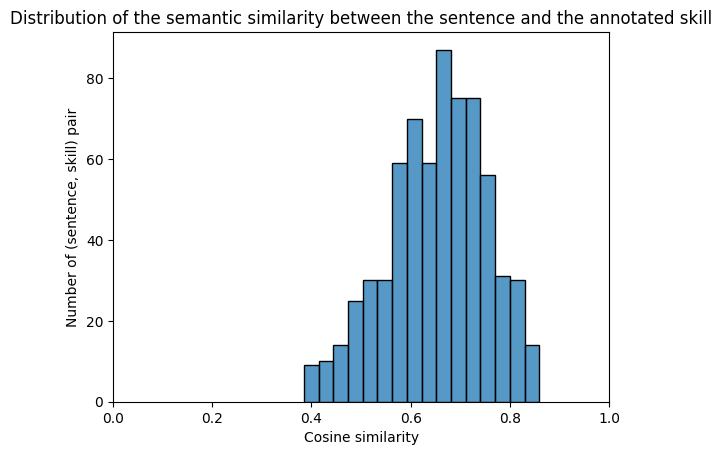

In [10]:
g = sns.histplot(data=tech_test, x="sim")
g.set_xlim((0, 1))
g.set_title("Distribution of the semantic similarity between the sentence and the annotated skill")
g.set_xlabel("Cosine similarity")
g.set_ylabel("Number of (sentence, skill) pair")

Let's look at some qualitative examples :

In [21]:
def display_top_rows(df, k):
    for i, (_, (sentence, label, sim)) in enumerate(df.head(k).iterrows()):
        print(i + 1, ") sentence : ", sentence)
        print("\t> label : ", label)
        print("\t> sim", sim)
        


print("BOTTOM FIVE EXAMPLES :")
display_top_rows(tech_test.sort_values("sim")[["sentence", "label", "sim"]], 5)
print("TOP FIVE EXAMPLES :")
display_top_rows(tech_test.sort_values("sim", ascending=False)[["sentence", "label", "sim"]], 5)


BOTTOM FIVE EXAMPLES :
1 ) sentence :  agile architecture
	> label :  software architecture models
	> sim 0.38462191820144653
2 ) sentence :  agile architecture
	> label :  software architecture models
	> sim 0.38462191820144653
3 ) sentence :  Industry: Cloud Services Information Technology Technology Consulting
	> label :  provide technical expertise
	> sim 0.39169931411743164
4 ) sentence :  Senior Java Software Engineer ( VP ) As a member of our <ORGANIZATION> <ORGANIZATION> <ORGANIZATION> we look first and foremost for people who are passionate around solving business problems through innovation & engineering practices .
	> label :  innovation processes
	> sim 0.3989642262458801
5 ) sentence :  As an experienced member of our Software Engineering Group we look first and foremost for people who are passionate around solving business problems through innovation & engineering practices .
	> label :  innovation processes
	> sim 0.4017237424850464
TOP FIVE EXAMPLES :
1 ) sentence :  Ex

## Compute the cross similarities between skills

In [7]:
skills_names = list(emb_tax["name"].values)
skills_embeddings = torch.cat(list(emb_tax["embeddings"].values)).numpy()

cross_skill_sim = cosine_similarity(skills_embeddings, skills_embeddings)

Example for skill "PostgreSQL"

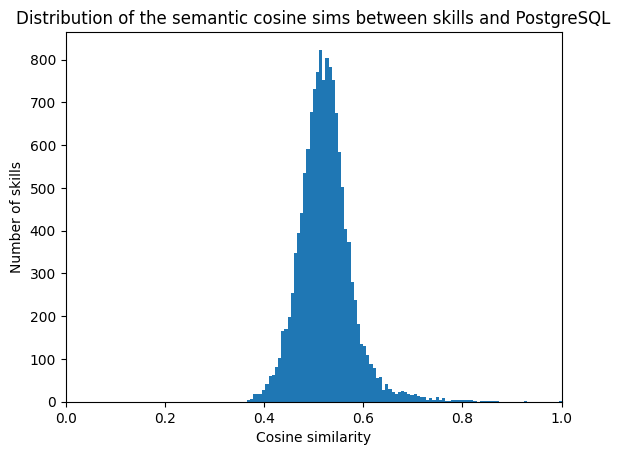

In [98]:
psql_idx = skills_names.index("PostgreSQL")

psql_sims = cross_skill_sim[psql_idx]


f, a = plt.subplots()
plt.hist(psql_sims, bins=100);
a.set_title("Distribution of the semantic cosine sims between skills and PostgreSQL")
a.set_xlabel("Cosine similarity")
a.set_ylabel("Number of skills")
a.set_xlim((0, 1));

Example with 'manage musical staff'

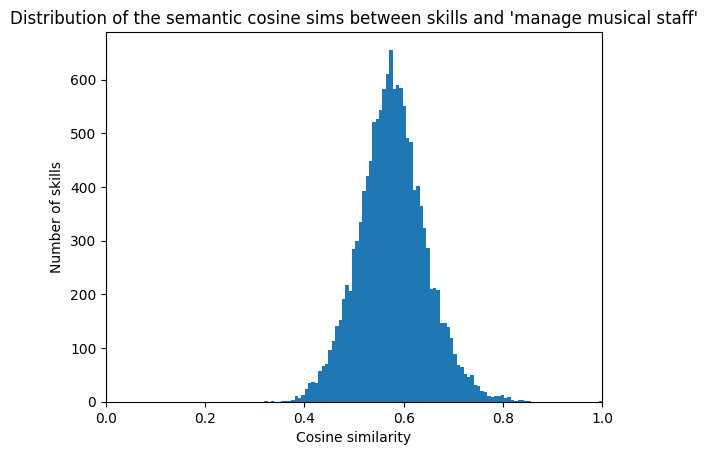

In [9]:
psql_idx = skills_names.index("manage musical staff")

psql_sims = cross_skill_sim[psql_idx]


f, a = plt.subplots()
plt.hist(psql_sims, bins=100);
a.set_title("Distribution of the semantic cosine sims between skills and 'manage musical staff'")
a.set_xlabel("Cosine similarity")
a.set_ylabel("Number of skills")
a.set_xlim((0, 1));

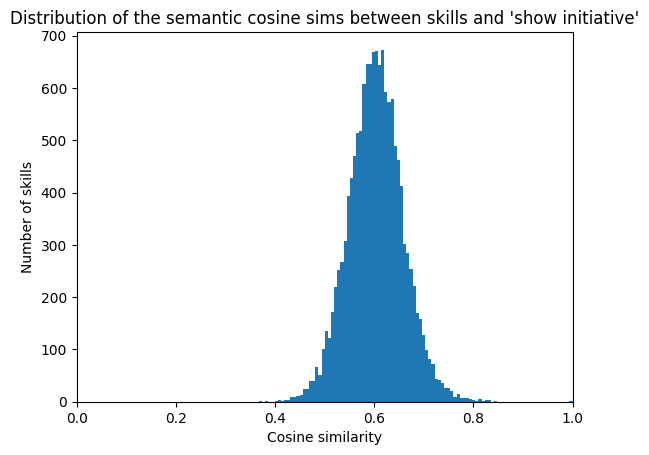

In [10]:
psql_idx = skills_names.index('show initiative')

psql_sims = cross_skill_sim[psql_idx]


f, a = plt.subplots()
plt.hist(psql_sims, bins=100);
a.set_title("Distribution of the semantic cosine sims between skills and 'show initiative'")
a.set_xlabel("Cosine similarity")
a.set_ylabel("Number of skills")
a.set_xlim((0, 1));

In [127]:
def get_kNN(label, k, cross_sims=cross_skill_sim, flipped=True):
    label_idx = skills_names.index(label)
    kNN = cross_sims[label_idx].argsort()[::-1 if flipped else 1][1:k+1] 
    kNN_labels = []
    for nn in kNN:
        kNN_labels.append(skills_names[nn])
    return kNN_labels


In [104]:
examples = ["PostgreSQL", 'show initiative', 'manage musical staff']
for ex in examples:
    print("> ", ex)
    nns = get_kNN(ex, 5)
    for i, nn in enumerate(nns):
        print("\t", i + 1, ")", nn)

>  PostgreSQL
	 1 ) MySQL
	 2 ) SQL Server
	 3 ) Oracle Relational Database
	 4 ) NoSQL
	 5 ) database management systems
>  show initiative
	 1 ) assertiveness
	 2 ) act reliably
	 3 ) moderate a debate
	 4 ) show determination
	 5 ) assess others
>  manage musical staff
	 1 ) prepare rehearsals
	 2 ) conduct military music services
	 3 ) represent artistic production
	 4 ) complete final musical scores
	 5 ) identify requirements of the work


Simply computing the number of skills per sentence in the annotated dataset :

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


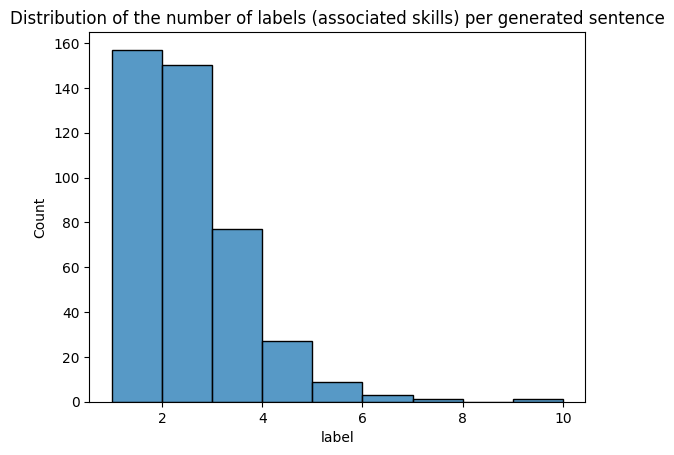

In [13]:
g = sns.histplot(
    data=tech_test[["sentence", "label"]]\
        .drop_duplicates()\
        .groupby("sentence")\
        .count()\
        .reset_index(),
    x="label",
    binwidth=1
)

g.set_title("Distribution of the number of labels (associated skills) per generated sentence");

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


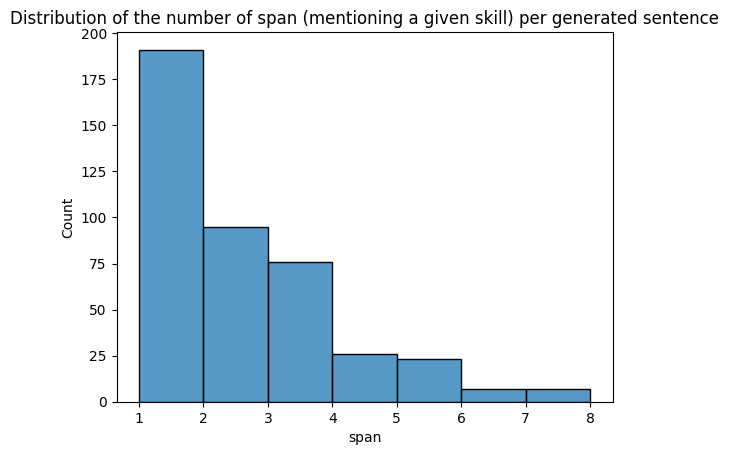

In [14]:
g = sns.histplot(
    data=tech_test[["sentence", "span"]]\
        .drop_duplicates()\
        .groupby("sentence")\
        .count()\
        .reset_index(),
    x="span",
    binwidth=1
)

g.set_title("Distribution of the number of span (mentioning a given skill) per generated sentence");

### Intra document similarities

In [37]:
unk_label = ["LABEL NOT PRESENT", "UNDERSPECIFIED"]
multilabel = tech_test[~tech_test.label.isin(unk_label)][["sentence", "label"]]\
    .groupby("sentence")\
    .agg({"label": lambda x : x.tolist()})\
    .reset_index()
multilabel["all_embeddings"] = multilabel["label"].progress_apply(
    lambda names : \
        torch.cat([emb_tax[emb_tax.name == name]["embeddings"].iloc[0] for name in names]).detach().numpy()
)

  0%|          | 0/338 [00:00<?, ?it/s]

In [15]:
def doc_cross_cos_sim(all_embeddings, other_embeddings=None):
    if(other_embeddings is None):
        other_embeddings = all_embeddings
    all_cross = cosine_similarity(all_embeddings, other_embeddings)
    N, M = all_cross.shape
    no_redudancy = (np.tri(N, M, -1) * all_cross).flatten()
    return no_redudancy[no_redudancy != 0]

multilabel["intra_doc_sim"] = multilabel["all_embeddings"].apply(doc_cross_cos_sim)

In [82]:
ne_multilabel = multilabel[multilabel.intra_doc_sim.apply(len).astype(bool)]

/tmp/ipykernel_25992/418556702.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ne_multilabel["mean_intra_doc_sim"] = ne_multilabel["intra_doc_sim"].apply(lambda x : x.mean())
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operatin

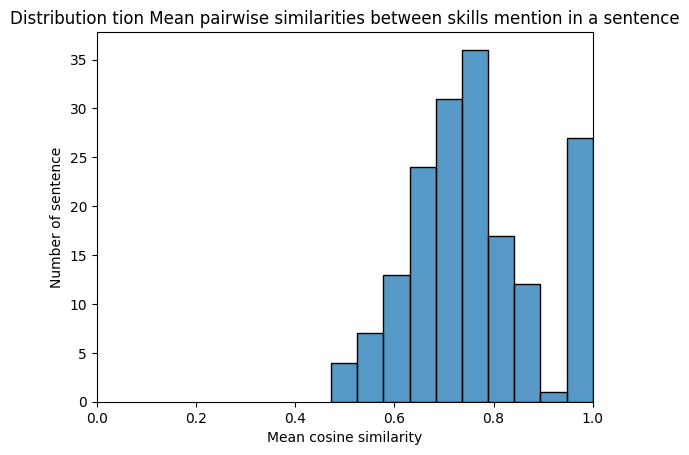

In [92]:
ne_multilabel["mean_intra_doc_sim"] = ne_multilabel["intra_doc_sim"].apply(lambda x : x.mean())
g = sns.histplot(data=ne_multilabel, x="mean_intra_doc_sim")
g.set_title("Distribution tion Mean pairwise similarities between skills mention in a sentence")
g.set_xlabel("Mean cosine similarity")
g.set_ylabel("Number of sentence")
g.set_xlim((0, 1));

====> last peak is due to multiple redundancies in the label for a given sentence

In [96]:
print(len(tech_test.index))
print(len(tech_test[["sentence", "label"]].drop_duplicates().index))


1164
876


In [115]:
all_sims = ne_multilabel["mean_intra_doc_sim"].explode()


all_sims = all_sims[all_sims != 1]
mu = str(round(all_sims.mean(), 2))
sig = str(round(all_sims.std(), 2))
display(Markdown("${X}$ if the distribution of the mean intra doc similarity"))
display(Markdown("$\mathbb{E}(X) \sim \mathcal{N}(" +  mu +", (" + sig + ")^2)$"))

${X}$ if the distribution of the mean intra doc similarity

$\mathbb{E}(X) \sim \mathcal{N}(0.75, (0.12)^2)$

We restart the qualitative example we've seen before but extracting skills of similarity centered in $0.75$.

In [118]:
mu

'0.75'

We take, for each skills the 5 skills centered in $\mu = 0.75$ to try to reproduce the distribution we have for annotated dataset.

Taking the frequency might still be very important because "IBM WebSphere" is very obscure whereas "PostgreSQL" is very popular.

In [129]:
examples = ["PostgreSQL", 'show initiative', 'manage musical staff']
for ex in examples:
    print("> ", ex)
    cross_sims = np.abs(cross_skill_sim - float(mu))
    nns = get_kNN(ex, 5, cross_sims, flipped=False)
    for i, nn in enumerate(nns):
        print("\t", i + 1, ")", nn)

>  PostgreSQL
	 1 ) IBM WebSphere
	 2 ) MDX
	 3 ) LDAP
	 4 ) Microsoft Visual C++
	 5 ) penetration testing tool
>  show initiative
	 1 ) develop investigation strategy
	 2 ) map out customer requirements into pragmatic actions
	 3 ) participatory decision-making
	 4 ) define an approach to your fight dicipline
	 5 ) apply change management
>  manage musical staff
	 1 ) monitor trends in interior design
	 2 ) demonstrate a technical foundation in musical instruments
	 3 ) develop an artistic approach to your interpretation
	 4 ) coordinate artistic production
	 5 ) critique other writers


## Studing Level differences

In [121]:
ESCO_DIR = "../../../esco/"
tech_skills = pd.read_csv(ESCO_DIR + "tech_managment_taxonomy_narrow.csv")
tech_skills_names = list(tech_skills.name.unique())
tech_emb_tax = emb_tax[emb_tax.name.isin(tech_skills_names)]

In [122]:
level_embeds = tech_emb_tax.merge(tech_skills[["name", "Type Level 1"]], on="name")\
    .groupby("Type Level 1").agg({'embeddings': lambda x : torch.cat(list(x.values)).numpy()})\
    .reset_index()

level_embeds.embeddings.apply(lambda x : print(x.shape));

(78, 768)
(318, 768)
(676, 768)
(413, 768)
(309, 768)


In [123]:
level_sims = np.zeros((len(level_embeds.index), len(level_embeds.index)))
for i, (leveli, embsi) in level_embeds.iterrows():
    for j, (levelj, embsj) in level_embeds.iterrows():
        level_sims[i, j] = doc_cross_cos_sim(embsi, embsj).mean()
    

In [124]:
level_embeds

,Type Level 1,embeddings
0,"communication, collaboration and creativity","[[0.7282062, 0.35601136, -1.2155267, 0.0769373..."
1,information and communication technologies (icts),"[[0.9489219, -0.79856044, 0.5058693, 0.8152102..."
2,information skills,"[[1.4159505, -1.4062278, -0.23259674, 0.439109..."
3,management skills,"[[0.9425589, 0.1468395, -1.0258644, 0.9182517,..."
4,working with computers,"[[1.5717837, -0.40427476, -0.23234841, -0.0948..."


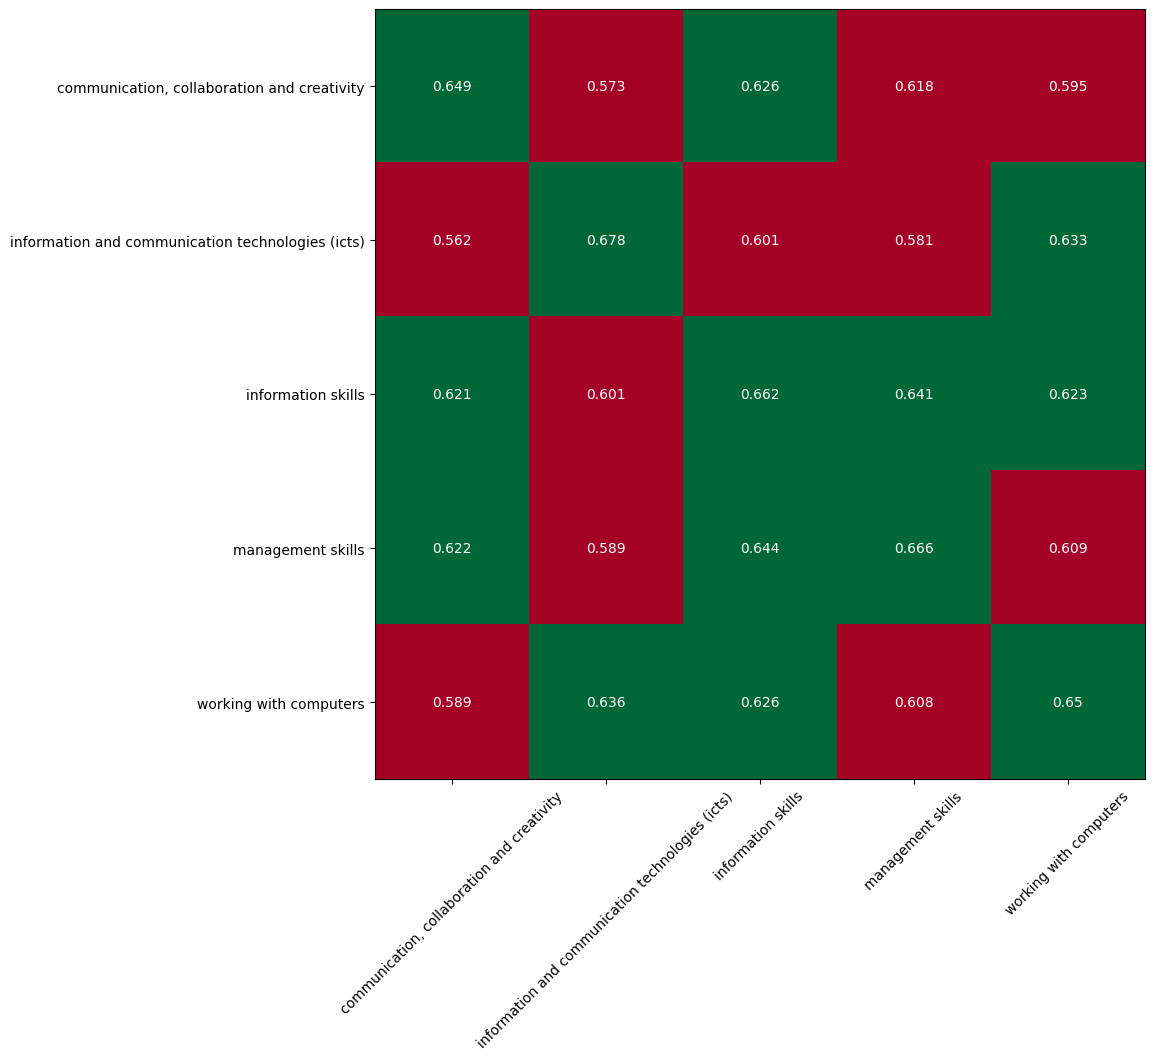

In [125]:
f, a = plt.subplots(figsize=(10, 10))

mask = (level_sims > level_sims.mean()).astype(int)
plt.imshow(mask, cmap='RdYlGn')
for (j,i),label in np.ndenumerate(level_sims):
    a.text(i,j,round(label, 3),ha='center',va='center', color="white")

a.set_yticks(level_embeds.index)
a.set_yticklabels(level_embeds["Type Level 1"])
a.set_xticks(level_embeds.index)
a.set_xticklabels(level_embeds["Type Level 1"], rotation=45);

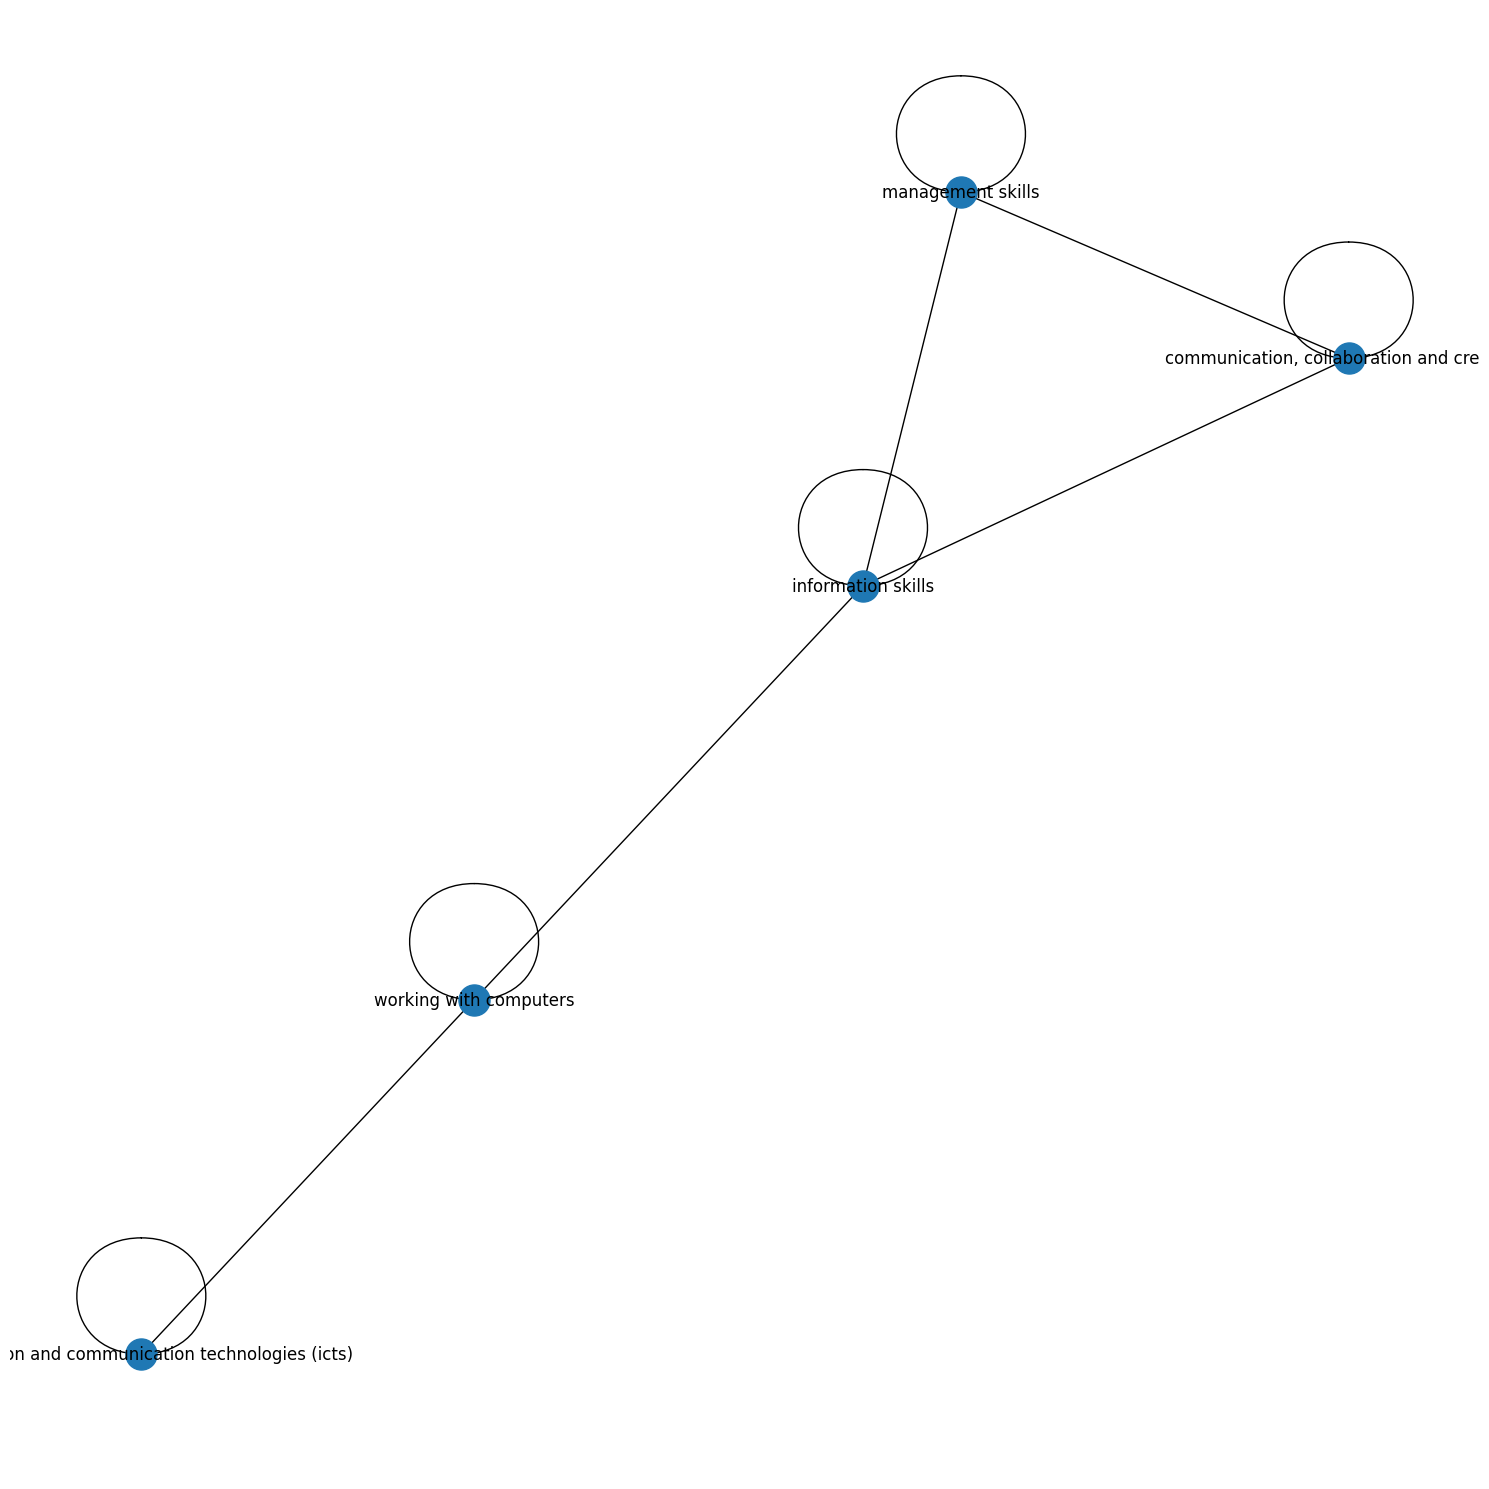

In [126]:
import networkx as nx

f, a = plt.subplots(figsize=(15, 15))
def show_graph_with_labels(adjacency_matrix, mylabels):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=500, labels=mylabels, with_labels=True)
    plt.tight_layout()
    plt.show()


A = mask
show_graph_with_labels(A, {k: v for k, v in enumerate(level_embeds["Type Level 1"].values)})

['communication, collaboration and creativity',
 'information and communication technologies (icts)',
 'information skills',
 'management skills',
 'working with computers']

/tmp/ipykernel_48999/4077021948.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_xticklabels(a.get_xticklabels(), rotation=90);


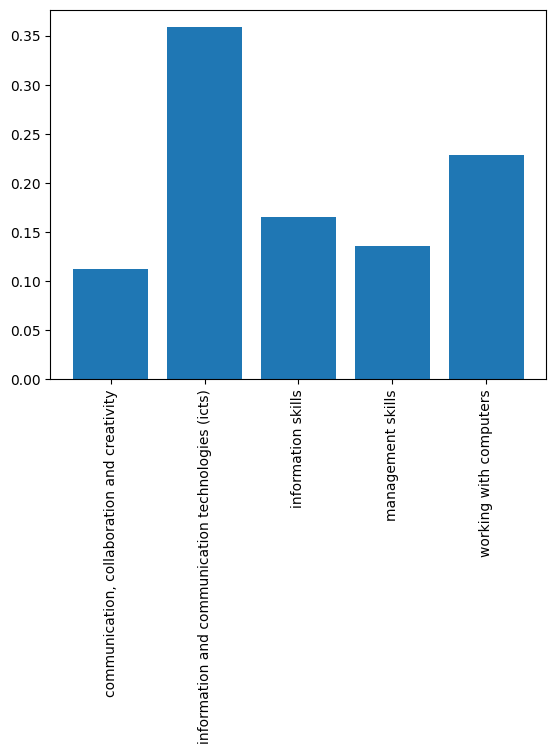

In [127]:
level1 = list(level_embeds["Type Level 1"].values)
display(level1)
softmax = lambda x, T : np.exp(x / T) / np.exp(x / T).sum()
f, a = plt.subplots()
plt.bar(height=softmax(level_sims[level1.index("information and communication technologies (icts)")], 0.1), x=level1)
a.set_xticklabels(a.get_xticklabels(), rotation=90);


## Studying the kNN per Levels

In [ ]:
tech_emb_tax = tech_emb_tax.merge(tech_skills[["name", "Type Level 1"]], on="name")
emb_tax_levels = [tech_emb_tax[tech_emb_tax["Type Level 1"] == l1] for l1 in level1]

In [174]:
def get_kNN_in_all_levels(skillname, sl1, threshold=0.0, verbose=True):
    skill_embedding = tech_emb_tax[tech_emb_tax["name"] == skillname]["embeddings"].values[0].numpy()
    k = 5
    kNN_in_levels = {}
    for i, emb_tax_level in enumerate(emb_tax_levels):
        
        sims = cosine_similarity(skill_embedding, torch.cat(list(emb_tax_level["embeddings"].values)).numpy())[0]
        if(level1.index(sl1) == i):
            idxs = sims.argsort()[::-1][1:k+1]
        else :
            idxs = sims.argsort()[::-1][:k]

        idxs = [idx for idx in idxs if sims[idx] > threshold]
        if(verbose):
            print("-"*50)
            print("Level : ", level1[i])
        knns = []
        for idx in idxs:
            if(verbose):
                print(f"\t- {emb_tax_level.iloc[idx]['name']} (sim = {round(sims[idx], 4)})")
            knns.append([emb_tax_level.iloc[idx]['name'], round(sims[idx], 4)])
        kNN_in_levels[level1[i]] = knns

    return kNN_in_levels


dist = np.ones(10) / 10 ## combination size dist
level1 = list(level_embeds["Type Level 1"].values)
softmax = lambda x, T : np.exp(x / T) / np.exp(x / T).sum()
dists = {}
for l1 in level1:
    dists[l1] = softmax(level_sims[level1.index("information and communication technologies (icts)")], 0.1)



def get_combination_diverse(skill, l1, threshold=0.0):
    comb_size = np.random.choice(np.arange(1, 11), p=dist)
    select_dist = dists[l1]
    kNNs = get_kNN_in_all_levels(skill, l1, verbose=False)
    comb_levels = np.random.choice(level1, size=comb_size, p=select_dist, replace=True)
    combinations = []
    for comb_level in comb_levels:
        select = kNNs[comb_level][0]
        kNNs[comb_level].remove(select)
        combinations.append(select)
    return combinations

In [133]:
get_kNN_in_all_levels("SQL");

--------------------------------------------------
Level :  communication, collaboration and creativity
	- communicate mathematical information (sim = 0.7330999970436096)
	- condense information (sim = 0.715399980545044)
	- use communication techniques (sim = 0.7028999924659729)
	- discern written communication (sim = 0.6877999901771545)
	- manage youth information services (sim = 0.6866999864578247)
--------------------------------------------------
Level :  information and communication technologies (icts)
	- SQL (sim = 1.0)
	- SPARQL (sim = 0.9624000191688538)
	- XQuery (sim = 0.9498999714851379)
	- LINQ (sim = 0.9362999796867371)
	- N1QL (sim = 0.9348999857902527)
--------------------------------------------------
Level :  information skills
	- process data (sim = 0.7901999950408936)
	- supervise data entry (sim = 0.7814000248908997)
	- memorise large amounts of information (sim = 0.772599995136261)
	- develop scientific research protocols (sim = 0.771399974822998)
	- analyse infor

In [130]:
get_kNN_in_all_levels("Hadoop");

--------------------------------------------------
Level :  communication, collaboration and creativity
	- deliver visual presentation of data (sim = 0.6870999932289124)
	- communicate mathematical information (sim = 0.6527000069618225)
	- manage youth information services (sim = 0.6473000049591064)
	- use communication techniques (sim = 0.6450999975204468)
	- condense information (sim = 0.6190999746322632)
--------------------------------------------------
Level :  information and communication technologies (icts)
	- Hadoop (sim = 1.0)
	- MarkLogic (sim = 0.8996000289916992)
	- data extraction, transformation and loading tools (sim = 0.8873999714851379)
	- Oracle Warehouse Builder (sim = 0.8855999708175659)
	- Oracle Data Integrator (sim = 0.871399998664856)
--------------------------------------------------
Level :  information skills
	- manage database (sim = 0.8205000162124634)
	- manage findable accessible interoperable and reusable data (sim = 0.8061000108718872)
	- manage data (

In [131]:
get_kNN_in_all_levels("perform energy simulations");

--------------------------------------------------
Level :  communication, collaboration and creativity
	- communicate mathematical information (sim = 0.7641000151634216)
	- create weather maps (sim = 0.7365000247955322)
	- deliver visual presentation of data (sim = 0.7102000117301941)
	- describe chemical innovation in products (sim = 0.6912000179290771)
	- mark the stage area (sim = 0.6899999976158142)
--------------------------------------------------
Level :  information and communication technologies (icts)
	- ICT network simulation (sim = 0.8173999786376953)
	- CAE software (sim = 0.8090000152587891)
	- database development tools (sim = 0.8037999868392944)
	- unified modelling language (sim = 0.7979000210762024)
	- task algorithmisation (sim = 0.7965999841690063)
--------------------------------------------------
Level :  information skills
	- perform energy simulations (sim = 1.0)
	- develop predictive models (sim = 0.857200026512146)
	- compare survey computations (sim = 0.8483

In [160]:
get_kNN_in_all_levels("SQL", verbose=False)

[['use query languages', 0.8415],
 ['operate relational database management system', 0.8299],
 ['use databases', 0.8163],
 ['develop translation memory software', 0.7964],
 ['define database physical structure', 0.7945]]

In [172]:
for _ in range(5):
    display("-"*50)
    display(get_combination_diverse("SQL", "information and communication technologies (icts)"))

'--------------------------------------------------'

[['SPARQL', 0.9624],
 ['XQuery', 0.9499],
 ['LINQ', 0.9363],
 ['manage standards for data exchange', 0.7977]]

'--------------------------------------------------'

[['SPARQL', 0.9624], ['use query languages', 0.8415], ['XQuery', 0.9499]]

'--------------------------------------------------'

[['use query languages', 0.8415],
 ['communicate mathematical information', 0.7331],
 ['SPARQL', 0.9624],
 ['operate relational database management system', 0.8299],
 ['XQuery', 0.9499],
 ['LINQ', 0.9363]]

'--------------------------------------------------'

[['process data', 0.7902],
 ['communicate mathematical information', 0.7331],
 ['use query languages', 0.8415],
 ['supervise data entry', 0.7814],
 ['manage standards for data exchange', 0.7977],
 ['develop automated migration methods', 0.7563],
 ['create SCORM packages', 0.7379],
 ['memorise large amounts of information', 0.7726],
 ['develop business case', 0.7343],
 ['condense information', 0.7154]]

'--------------------------------------------------'

[['use query languages', 0.8415]]

In [175]:
for _ in range(5):
    display("-"*50)
    display(get_combination_diverse("perform energy simulations", "information skills"))

'--------------------------------------------------'

[['ICT network simulation', 0.8174],
 ['develop optical test procedures', 0.8292],
 ['CAE software', 0.809],
 ['use thermal analysis', 0.8366],
 ['develop predictive models', 0.8572],
 ['database development tools', 0.8038],
 ['communicate mathematical information', 0.7641],
 ['unified modelling language', 0.7979],
 ['develop microelectromechanical system test procedures', 0.8168]]

'--------------------------------------------------'

[['use thermal analysis', 0.8366],
 ['ICT network simulation', 0.8174],
 ['develop predictive models', 0.8572],
 ['use software tools for site modelling', 0.8359]]

'--------------------------------------------------'

[['develop predictive models', 0.8572],
 ['ICT network simulation', 0.8174],
 ['CAE software', 0.809],
 ['use thermal analysis', 0.8366],
 ['compare survey computations', 0.8484],
 ['database development tools', 0.8038],
 ['use software tools for site modelling', 0.8359],
 ['use polygonal modelling', 0.8345],
 ['unified modelling language', 0.7979]]

'--------------------------------------------------'

[['use thermal analysis', 0.8366],
 ['use software tools for site modelling', 0.8359],
 ['ICT network simulation', 0.8174],
 ['develop predictive models', 0.8572],
 ['develop optical test procedures', 0.8292],
 ['compare survey computations', 0.8484]]

'--------------------------------------------------'

[['develop predictive models', 0.8572],
 ['ICT network simulation', 0.8174],
 ['CAE software', 0.809],
 ['use thermal analysis', 0.8366],
 ['database development tools', 0.8038],
 ['develop optical test procedures', 0.8292],
 ['use software tools for site modelling', 0.8359],
 ['compare survey computations', 0.8484]]

In [177]:
for _ in range(5):
    display("-"*50)
    display(get_combination_diverse("develop terminology databases", "information skills"))

'--------------------------------------------------'

[['database', 0.8327],
 ['migrate existing data', 0.828],
 ['smart contract', 0.7998],
 ['TripleStore', 0.7808],
 ['maintain database', 0.8213],
 ['develop methods for choreographic integration', 0.8234],
 ['manage ICT data classification', 0.8202],
 ['create underwriting guidelines', 0.8485]]

'--------------------------------------------------'

[['present items during auction', 0.8138]]

'--------------------------------------------------'

[['present items during auction', 0.8138],
 ['database', 0.8327],
 ['create underwriting guidelines', 0.8485]]

'--------------------------------------------------'

[['present items during auction', 0.8138],
 ['database', 0.8327],
 ['smart contract', 0.7998],
 ['TripleStore', 0.7808],
 ['create underwriting guidelines', 0.8485],
 ['develop methods for choreographic integration', 0.8234],
 ['migrate existing data', 0.828]]

'--------------------------------------------------'

[['create underwriting guidelines', 0.8485],
 ['migrate existing data', 0.828],
 ['develop methods for choreographic integration', 0.8234],
 ['maintain database', 0.8213],
 ['database', 0.8327],
 ['smart contract', 0.7998],
 ['synthesise financial information', 0.8371],
 ['create credit policy', 0.8177]]